In [1]:
'''

load original df

'''

import pandas as pd
import os
import numpy as np
from scipy.stats import mannwhitneyu
import seaborn as sns
from statannotations.Annotator import Annotator
import warnings
warnings.filterwarnings('ignore') #supresses warnings for now
#warnings.filterwarnings(action='once') #shows warnings once

dataFilePath = os.path.join(os.getcwd(),'Data')

#kicsSVdf = pd.read_csv(os.path.join(dataFilePath,'kics_structural_variations.txt'), sep = '\t', header = 0)
kicsTEdf = pd.read_csv(os.path.join(dataFilePath,'kics_transposable_elements.txt'), sep = '\t', header = 0)
#lfsSVdf = pd.read_csv(os.path.join(dataFilePath,'lfs_structural_variations.txt'), sep = '\t', header = 0)
lfsTEdf = pd.read_csv(os.path.join(dataFilePath,'lfs_transposable_elements.txt'), sep = '\t', header = 0)
#kicsClinicdf = pd.read_csv(os.path.join(dataFilePath,'kics_clinical_main.tsv'), sep = '\t', header = 0)
#lfsClinicdf = pd.read_csv(os.path.join(dataFilePath,'lfs_clinical_main.tsv'), sep = '\t', header = 0)


In [2]:
sns.set(font_scale=1.5)

dog = kicsTEdf.columns
print(dog.tolist())
print(kicsTEdf.head(30))
print(lfsTEdf.columns)
print(lfsTEdf.head(30))

#keep SV_chrom, SV_length, SV_type, Location, Location2, 

#AnnotSV type => Annotation_mode



['AnnotSV_ID', 'SV_chrom', 'SV_start', 'SV_end', 'SV_length', 'SV_type', 'Samples_ID', 'ID', 'REF', 'ALT', 'QUAL', 'FILTER', 'INFO', 'FORMAT', 'xTea', 'MELT', 'Annotation_mode', 'CytoBand', 'Gene_name', 'Gene_count', 'Tx', 'Tx_start', 'Tx_end', 'Overlapped_tx_length', 'Overlapped_CDS_length', 'Overlapped_CDS_percent', 'Frameshift', 'Exon_count', 'Location', 'Location2', 'Dist_nearest_SS', 'Nearest_SS_type', 'Intersect_start', 'Intersect_end', 'RE_gene', 'P_gain_phen', 'P_gain_hpo', 'P_gain_source', 'P_gain_coord', 'P_loss_phen', 'P_loss_hpo', 'P_loss_source', 'P_loss_coord', 'P_ins_phen', 'P_ins_hpo', 'P_ins_source', 'P_ins_coord', 'P_snvindel_nb', 'P_snvindel_phen', 'B_gain_source', 'B_gain_coord', 'B_gain_AFmax', 'B_loss_source', 'B_loss_coord', 'B_loss_AFmax', 'B_ins_source', 'B_ins_coord', 'B_ins_AFmax', 'B_inv_source', 'B_inv_coord', 'B_inv_AFmax', 'TAD_coordinate', 'ENCODE_experiment', 'GC_content_left', 'GC_content_right', 'Repeat_coord_left', 'Repeat_type_left', 'Repeat_coord_r

In [3]:
"""
'ALT' Clean up
"""

kicsTEdf['ALT'] = kicsTEdf['ALT'].str.replace("<INS:ME:","")
kicsTEdf['ALT'] = kicsTEdf['ALT'].str.replace(">","")

lfsTEdf['ALT'] = lfsTEdf['ALT'].str.replace("<INS:ME:","")
lfsTEdf['ALT'] = lfsTEdf['ALT'].str.replace(">","")
print(lfsTEdf['ALT'].value_counts())

#print(lfsTEdf['ALT'].value_counts())

ALU      90163
LINE1     4342
SVA       2712
Name: ALT, dtype: int64


In [4]:
# listValSearch = ['291775', '298313', '315666', '320118', '18_1907']
# # searched for kID of 63, 83, 156, 171, 219
# # kID 120 141 and 232 do not have any matches...
# #what would make this that much better is if it was a dict. Computationally less heavy?

# for i in listValSearch: 
#     kicsSVdf.drop(kicsSVdf[kicsSVdf['sample_id'].str.contains(i)==True].index, inplace = True)


In [5]:

kicsTEF = kicsTEdf.loc[(kicsTEdf['Annotation_mode'] == 'full')]
lfsTEF = lfsTEdf.loc[(lfsTEdf['Annotation_mode'] == 'full')]

kicsTEF['SV_chrom'] = kicsTEF['SV_chrom'].astype(str)
lfsTEF['SV_chrom'] = lfsTEF['SV_chrom'].astype(str)

kicsTEF['Samples_ID'] = kicsTEF['Samples_ID'].astype(str).str.replace(".realigned-recalibrated","")
lfsTEF['Samples_ID'] = lfsTEF['Samples_ID'].astype(str)

kicsTEnum = kicsTEF['Samples_ID'].count()
lfsTEnum = lfsTEF['Samples_ID'].count()

mergedTEdf = pd.DataFrame(data = {'kics':kicsTEF['SV_type'], 'kChrom':kicsTEF['SV_chrom'], 
                                  'kAlt':kicsTEF['ALT'], 'lAlt':lfsTEF['ALT'],
                                  'kID':kicsTEF['Samples_ID'], 'lID': lfsTEF['Samples_ID'],
                                  'lfs':lfsTEF['SV_type'], 'lChrom':lfsTEF['SV_chrom']})
print(mergedTEdf)
print(mergedTEdf['kics'].value_counts())



       kics kChrom kAlt lAlt     kID   lID  lfs lChrom
0       INS      1  ALU  SVA  321323  4257  INS      1
1       NaN    NaN  NaN  SVA     NaN  4257  INS      1
2       INS      1  ALU  SVA  321323  4257  INS      1
3       NaN    NaN  NaN  SVA     NaN  4257  INS     11
4       INS      1  ALU  NaN  321323   NaN  NaN    NaN
...     ...    ...  ...  ...     ...   ...  ...    ...
127345  INS      X  ALU  NaN  292600   NaN  NaN    NaN
127346  INS      X  ALU  NaN  292600   NaN  NaN    NaN
127348  INS      X  ALU  NaN  292600   NaN  NaN    NaN
127349  INS      X  ALU  NaN  292600   NaN  NaN    NaN
127350  INS      X  ALU  NaN  292600   NaN  NaN    NaN

[108660 rows x 8 columns]
INS    87850
Name: kics, dtype: int64


In [6]:
from matplotlib import pyplot as plt

def boxplotPoints(title:list, column:list, df: pd.DataFrame , sizeH=20.50, sizeV=17.50, col='red', trans=0.25, outliers = True):
    plt.rcParams["figure.figsize"] = [sizeH, sizeV]
    plt.rcParams["figure.autolayout"] = True
    data = pd.DataFrame({
        t: df[c] for t,c in zip(title, column)})
    
    #print(data)
    plotTest = data
    plotTest = plotTest.stack().to_frame().reset_index().rename(columns={'level_1': 'iden', 0: 'value'}).drop('level_0', axis='columns')
    plotTest['cat'] = 1
    #print(plotTest.head(50))
    #data.boxplot()
    #BoxGraphMulti(plotTest, 'cat', 'value', 'iden')
    sns.boxplot(data=plotTest, x='iden', y='value', medianprops={"linewidth": 8, "color": 'black'}, showfliers = outliers)
    
    #plot with boxplot
    if outliers:
        sns.stripplot(x = 'iden',
                  y = 'value',
                      color = 'red',
                      alpha = 0.25,
                  data = plotTest)
    
    list1 = df[column[0]].dropna()
    list2 = df[column[1]].dropna()
    print(mannwhitneyu(list1,list2))
    plt.show()

titles = ['kics','lfs']
columns = titles


In [7]:
"""

1. Graph for frequency of SV types
2. Graphs for frequency of SV types specific to chromosomes

Function to graph bar graphs

"""

def BarGraphNormalized(label1: str, label2:str, df: pd.DataFrame, col1: str, col2: str,
                        xTitle: str, yTitle: str, divisor1: float, divisor2: float,
                        labels: list):
    #'kics', 'lfs', invdf, 'kchrom', 'lchrom', 'Chromosomes','Frequency','Graph2-INV',kicsSVnum, lfsSVnum

    title = label1 + " " + label2
    count1 = df[col1].value_counts()
    count2 = df[col2].value_counts()
    
    x_axis = np.arange(len(labels))
        
    for i in labels:
        if (not(i in count1)):
            add = pd.Series([0], index=[i])
            count1 = count1.append(add)
        if (not(i in count2)):
            add = pd.Series([0], index=[i])
            count2 = count2.append(add)
    
    plt.bar(x_axis - 0.2, [count1[a] for a in labels]/divisor1, 0.4, label = label1)
    plt.bar(x_axis + 0.2, [count2[a] for a in labels]/divisor2, 0.4, label = label2)

    plt.xticks(x_axis, labels)
    plt.xlabel(xTitle)
    plt.ylabel(yTitle)
    plt.title(title)
    plt.legend()
    plt.show()
    
xLabels = ['DEL','DUP','INV']
uniqueLabels = ['1','2','3','4','5','6','7','8','9','10',
                '11','12','13','14','15','16','17','18','19','20','21','22','X','Y']


In [8]:
"""

Testing group by

"""
#probably a better way to do this

kicsSVTypedf = pd.DataFrame(data = {'kics':kicsTEF['SV_type'], 
                                  'kId':kicsTEF['Samples_ID']})
lfsSVTypedf = pd.DataFrame(data = {'lId':lfsTEF['Samples_ID'],
                                  'lfs':lfsTEF['SV_type']})

#temp = mergedTEdf.groupby(['kId']).value_counts() #not sure how to use this, unsure if it's missing anything

##kics
ktemp = kicsSVTypedf.groupby(['kId']).value_counts()

##lfs
ltemp = lfsSVTypedf.groupby(['lId']).value_counts()

#print(ktemp.head(30))
#print(ktemp.index.get_level_values(0))

#get unique identifiers

uniqueK = kicsSVTypedf['kId'].unique()
uniqueL = lfsSVTypedf['lId'].unique()

#probably a better way, but itterate through the series and get the data 

def makeDataSet(identifiers, series: pd.Series, secondIndex: str)->list:
    
    dataList = []
    
    for i in identifiers:
        try:
            dataList.append(series[(i, secondIndex)])
        except:
            #pass
            dataList.append(0)

    return(dataList)


        
def makeUnequalDF(list1: list, list2: list) -> pd.DataFrame: #only for kics vs lfs D:
    tempDict = dict(kics = list1, lfs = list2)
    df = pd.DataFrame(dict([(k, pd.Series(v)) for k,v in tempDict.items()]))
    return df

# SV Type

In [9]:
kINSData = makeDataSet(uniqueK, ktemp, 'INS')
#print(kINSData)
lINSData = makeDataSet(uniqueL, ltemp, 'INS')
#print(lINSData)
tempINSDF = makeUnequalDF(kINSData, lINSData)

#print(tempINSDF)

## INS

MannwhitneyuResult(statistic=3627.5, pvalue=4.436398329639032e-05)


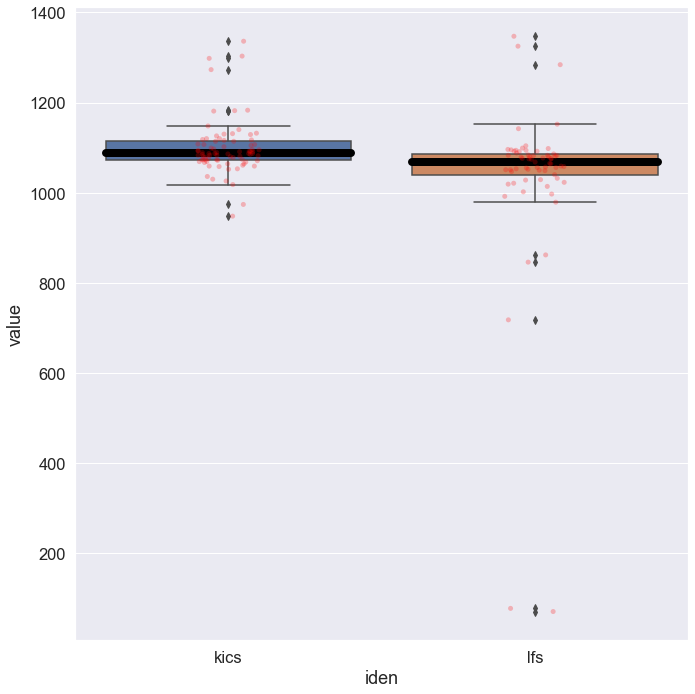

Index(['kics', 'lfs'], dtype='object')
    kics   lfs
22  1273  71.0
35  1120  78.0


In [15]:
boxplotPoints(titles, columns, tempINSDF, 10, 10)

#print(mergedTEdf[mergedTEdf['lfs']<200])
print(tempINSDF.columns)

print(tempINSDF[tempINSDF['lfs']<200])

In [ ]:
"""
ALU, LINE1, SVA
"""

kicsALT = pd.DataFrame(data={'ALT':kicsTEF['ALT'], 'id':kicsTEF['Samples_ID']})
lfsALT = pd.DataFrame(data={'ALT':lfsTEF['ALT'],'id':lfsTEF['Samples_ID']})

kicsALT = kicsALT.groupby('id')
kicsALT = kicsALT.value_counts().to_frame()
kicsALT = kicsALT.unstack(1)
kicsALT.columns = kicsALT.columns.droplevel(0)
kicsALT['dataset'] = 'kics'
print(kicsALT)

lfsALT = lfsALT.groupby('id')
lfsALT = lfsALT.value_counts().to_frame()
lfsALT = lfsALT.unstack(1)
lfsALT.columns = lfsALT.columns.droplevel(0)
lfsALT['dataset'] = 'lfs'

testing = pd.concat([kicsALT,lfsALT])
testing = testing.reset_index()
#print(testing)

plt.rcParams["figure.figsize"] = [5, 10]

sns.boxplot(data=testing, x='dataset', y='ALU', medianprops={"linewidth": 4, "color": 'black'})
plt.show()

print(mannwhitneyu(kicsALT['ALU'].dropna(),lfsALT['ALU'].dropna()))
#list1 = df[column[0]].dropna()
#        list2 = df[column[1]].dropna()
#        print(mannwhitneyu(list1,list2))



sns.boxplot(data=testing, x='dataset', y='LINE1', medianprops={"linewidth": 4, "color": 'black'})
plt.show()

print(mannwhitneyu(kicsALT['LINE1'].dropna(),lfsALT['LINE1'].dropna()))

sns.boxplot(data=testing, x='dataset', y='SVA', medianprops={"linewidth": 4, "color": 'black'})
plt.show()

print(mannwhitneyu(kicsALT['SVA'].dropna(),lfsALT['SVA'].dropna()))

#BoxGraphMulti(testing, '', 'id', 'dataset')

In [ ]:
"""
Based on chrom
"""

kicsChromAlt = pd.DataFrame(data={'ALT':kicsTEF['ALT'], 'id':kicsTEF['Samples_ID'], 'chrom':kicsTEF['SV_chrom']})
lfsChromAlt = pd.DataFrame(data={'ALT':lfsTEF['ALT'],'id':lfsTEF['Samples_ID'], 'chrom':lfsTEF['SV_chrom']})

#print(kicsChromAlt.columns)
dog = kicsChromAlt.groupby(['id','ALT','chrom']).size().unstack(fill_value=0)
dog = dog.stack().unstack(1)
print(dog.columns)
dog = dog.drop(['LINE1','SVA'], axis=1)
dog = dog.stack().unstack(1)

#print(lfsChromAlt.columns)
cat = lfsChromAlt.groupby(['id','ALT','chrom']).size().unstack(fill_value=0)
cat = cat.stack().unstack(1)
cat = cat.drop(['LINE1','SVA'],axis=1)
cat = cat.stack().unstack(1)
#print(lfsChromAlt)

AltKdf, normAltKdf = formatDataFrame(kicsChromAlt, ['id','ALT','chrom'], numBPChrom, uniqueK, uniqueLabels, 'ALU')
AltLdf, normAltLdf = formatDataFrame(lfsChromAlt, ['id','ALT','chrom'], numBPChrom, uniqueL, uniqueLabels, 'ALU')

print(normAltKdf)
# for i in uniqueLabels:
#     print(i)
#     dog = normAltKdf.loc[normAltKdf['chrom'] == i]
#     list1 = dog['normalized'].tolist()
#     cat = normAltLdf.loc[normAltLdf['chrom'] == i]
#     list2 = cat['normalized'].tolist()
#     print(mannwhitneyu(list1, list2))
    
    

AltKdf['dataset'] = 'kics'
AltLdf['dataset'] = 'lfs'
normAltKdf['dataset'] = 'kics'
normAltLdf['dataset'] = 'lfs'

AltMergedDf = pd.concat([AltKdf, AltLdf])
AltMergedDf.rename(columns = {0:'occ'}, inplace = True)
AltMergedDf.reset_index(inplace=True)
AltMergedDf.rename(columns = {'index':'chrom'}, inplace = True)

##ALU

plt.rcParams["figure.figsize"] = [10, 10]
BoxGraphMulti(AltMergedDf, 'chrom', 'occ', 'dataset')

normAltDf = pd.concat([normAltKdf, normAltLdf])
normAltDf.reset_index(inplace=True)

BoxGraphMulti(normAltDf, 'chrom', 'normalized', 'dataset')
    

In [ ]:
dog = kicsChromAlt.groupby(['id','ALT','chrom']).size().unstack(fill_value=0)
dog = dog.stack().unstack(1)
print(dog.columns)
dog = dog.drop(['ALU','SVA'], axis=1)
dog = dog.stack().unstack(1)

#print(lfsChromAlt.columns)
cat = lfsChromAlt.groupby(['id','ALT','chrom']).size().unstack(fill_value=0)
cat = cat.stack().unstack(1)
cat = cat.drop(['ALU','SVA'],axis=1)
cat = cat.stack().unstack(1)
#print(lfsChromAlt)

AltKdf, normAltKdf = formatDataFrame(kicsChromAlt, ['id','ALT','chrom'], numBPChrom, uniqueK, uniqueLabels, 'LINE1')
AltLdf, normAltLdf = formatDataFrame(lfsChromAlt, ['id','ALT','chrom'], numBPChrom, uniqueL, uniqueLabels, 'LINE1')

# for i in uniqueLabels:
#     print(i)
#     dog = normAltKdf.loc[normAltKdf['chrom'] == i]
#     list1 = dog['normalized'].tolist()
#     cat = normAltLdf.loc[normAltLdf['chrom'] == i]
#     list2 = cat['normalized'].tolist()
#     print(mannwhitneyu(list1, list2))

AltKdf['dataset'] = 'kics'
AltLdf['dataset'] = 'lfs'
normAltKdf['dataset'] = 'kics'
normAltLdf['dataset'] = 'lfs'

AltMergedDf = pd.concat([AltKdf, AltLdf])
AltMergedDf.rename(columns = {0:'occ'}, inplace = True)
AltMergedDf.reset_index(inplace=True)
AltMergedDf.rename(columns = {'index':'chrom'}, inplace = True)

###LINE1

BoxGraphMulti(AltMergedDf, 'chrom', 'occ', 'dataset')

normAltDf = pd.concat([normAltKdf, normAltLdf])
normAltDf.reset_index(inplace=True)

BoxGraphMulti(normAltDf, 'chrom', 'normalized', 'dataset')

In [ ]:
dog = kicsChromAlt.groupby(['id','ALT','chrom']).size().unstack(fill_value=0)
dog = dog.stack().unstack(1)
print(dog.columns)
dog = dog.drop(['LINE1','ALU'], axis=1)
dog = dog.stack().unstack(1)

#print(lfsChromAlt.columns)
cat = lfsChromAlt.groupby(['id','ALT','chrom']).size().unstack(fill_value=0)
cat = cat.stack().unstack(1)
cat = cat.drop(['LINE1','ALU'],axis=1)
cat = cat.stack().unstack(1)
#print(lfsChromAlt)

AltKdf, normAltKdf = formatDataFrame(kicsChromAlt, ['id','ALT','chrom'], numBPChrom, uniqueK, uniqueLabels, 'SVA')
AltLdf, normAltLdf = formatDataFrame(lfsChromAlt, ['id','ALT','chrom'], numBPChrom, uniqueL, uniqueLabels, 'SVA')

# for i in uniqueLabels:
#     print(i)
#     dog = normAltKdf.loc[normAltKdf['chrom'] == i]
#     list1 = dog['normalized'].tolist()
#     cat = normAltLdf.loc[normAltLdf['chrom'] == i]
#     list2 = cat['normalized'].tolist()
#     print(mannwhitneyu(list1, list2))

AltKdf['dataset'] = 'kics'
AltLdf['dataset'] = 'lfs'
normAltKdf['dataset'] = 'kics'
normAltLdf['dataset'] = 'lfs'

AltMergedDf = pd.concat([AltKdf, AltLdf])
AltMergedDf.rename(columns = {0:'occ'}, inplace = True)
AltMergedDf.reset_index(inplace=True)
AltMergedDf.rename(columns = {'index':'chrom'}, inplace = True)

###SVA

BoxGraphMulti(AltMergedDf, 'chrom', 'occ', 'dataset')

normAltDf = pd.concat([normAltKdf, normAltLdf])
normAltDf.reset_index(inplace=True)

BoxGraphMulti(normAltDf, 'chrom', 'normalized', 'dataset')

In [ ]:
"""
Normalised and Regular Graph
"""

#rename things later and put into function/i but this is the statistical test T-T
dog = kicsMore.groupby(grouping).size().unstack(fill_value=0)
#print(dog)
dog = dog.stack().unstack(1)
dog = dog.stack().unstack(1)

cat = lfsMore.groupby(grouping).size().unstack(fill_value=0)
cat = cat.stack().unstack(1)
cat = cat.stack().unstack(1)




newKdf, normKdf = formatDataFrame(kicsMore, grouping, numBPChrom, uniqueK, uniqueLabels, 'INS')
newLdf, normLdf = formatDataFrame(lfsMore, grouping, numBPChrom, uniqueL, uniqueLabels, 'INS')

# for i in uniqueLabels:
#     print(i)
#     dog = normAltKdf.loc[normAltKdf['chrom'] == i]
#     list1 = dog['normalized'].tolist()
#     cat = normAltLdf.loc[normAltLdf['chrom'] == i]
#     list2 = cat['normalized'].tolist()
#     print(mannwhitneyu(list1, list2))

#print(newKdf.index)
#print(newKdf.pivot( columns='index', values=0))

newKdf['dataset'] = 'kics'
newLdf['dataset'] = 'lfs'
normKdf['dataset'] = 'kics'
normLdf['dataset'] = 'lfs'

newMergedDf = pd.concat([newKdf, newLdf])
newMergedDf.rename(columns = {0:'occ'}, inplace = True)
newMergedDf.reset_index(inplace=True)
newMergedDf.rename(columns = {'index':'chrom'}, inplace = True)

print("DGOOOOOGG")
print(newMergedDf)

BoxGraphMulti(newMergedDf, 'chrom', 'occ', 'dataset')

normMergedDf = pd.concat([normKdf, normLdf])
normMergedDf.reset_index(inplace=True)

BoxGraphMulti(normMergedDf, 'chrom', 'normalized', 'dataset')